# Multi-Template Matching
## Tutorial 3 : Speed up the execution !

This tutorial shows 2 simple ways to increase the speed of execution with template matching.  
This is especially interesting if you need to run the detection on many images !

## Citations
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
You are free to distribute and/or modify this tutorial, provided you attribute the author:  

Multi-Template Matching python package online tutorial - _III - Speed-up execution_  
Laurent Thomas - 2019   
https://github.com/multi-template-matching/MultiTemplateMatching-Python/blob/master/tutorials/Tutorial3-SpeedingUp.ipynb


## Let's code !

In [1]:
# Set working directory to repos root when testing locally
%cd ..

C:\Users\Laurent\Documents\github\MultiTemplateMatching-Python


In [2]:
# 1st import the package and check its version
import matplotlib.pyplot as plt
import MTM
from MTM import matchTemplates, plotDetections
from skimage import io, draw, transform

In [3]:
print("MTM version: ", MTM.__version__)
%matplotlib inline

MTM version:  1.5.4


Let's open some test image (from the GitHub repository).  
This is a widefield microscopy image of a zebrafish larvae, mounted in a 96 well plate using agar.  
We will use Multi-Template-Matching for the detection of the head.  
This is useful since the larvae are not positioned exactly at the same spot in every well.  
For this tutorial we will use the same image though, as the goal is to compare the performance for different parameters.  

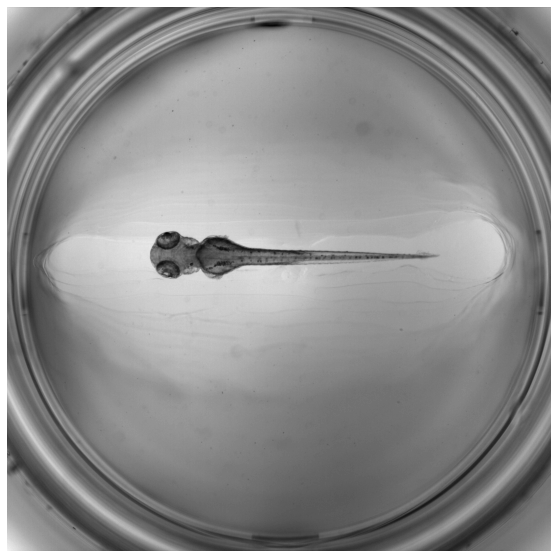

In [4]:
image = io.imread(r"images/Fish.tif", -1) # when testing locally
#image = cv2.imread(r"../images/Fish.tif", -1) # this assume you cloned the repo, or you run the notebook from Binder. You can also download the image separatly
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(image, cmap="gray")

As usually we define a template to search.  
Here we will crop the template from the image to be searched, in practice it is not a realistic scenario, one would would usually have a generic template different from the searched image.  
But here the point is to show the difference in computation time.

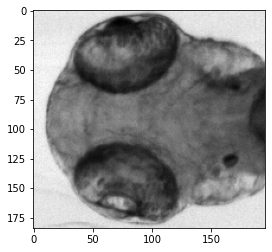

In [5]:
template = image[842:842+184, 528:528+196] 
plt.imshow(template, cmap="gray")

# I - Baseline execution
Let's call `matchTemplates` with the default parameters and record the execution time.

In [6]:
# Format the template into a list of tuple (label, templateImage)
listTemplates = [template]

%time listDetections = matchTemplates(image, listTemplates, nObjects=1)
listDetections

Wall time: 2.92 s


[(BoundingBox: 1.00, xyxy:(528, 842, 723, 1025), 0)]

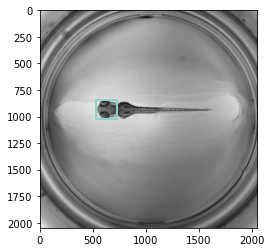

In [7]:
plotDetections(image, listDetections)

# II - Using a limited search region
Let's now use a search region as we know that the specimen is mounted in a gel, so located in a rectangle centered in the middle of the image (in white).  
Let see the impact on the computation time.

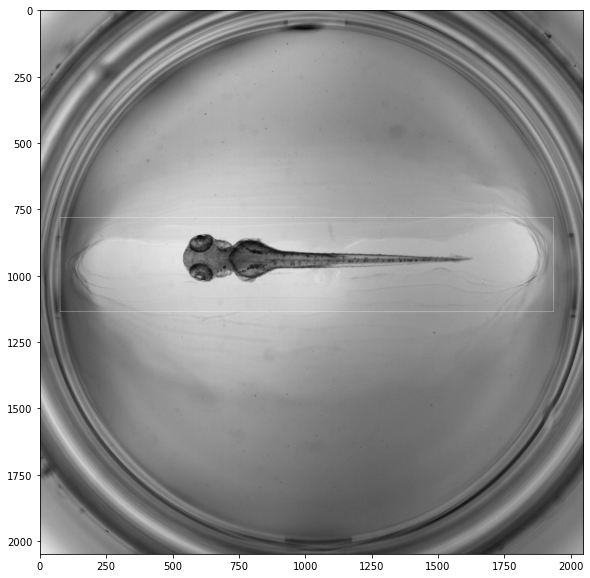

In [8]:
Overlay = image.copy()
o,v = draw.rectangle_perimeter( (781, 76), (781+353, 76+1856), shape = Overlay.shape )
Overlay[o,v] = 255
plt.figure(figsize = (10,10))
plt.imshow(Overlay, cmap="gray")

In [9]:
# The search region is provided by the searchBox argument in format (x,y,width,height)
%time listDetections = matchTemplates(image, listTemplates, nObjects=1, searchBox=(76,781,1856,353))
listDetections

Wall time: 767 ms


[(BoundingBox: 1.00, xyxy:(528, 842, 723, 1025), 0)]

__We get about 4x speed improvement !__  
The reason is simple, the comparison between the pixel intensities is now performed only for regions within the white rectangle.
Which is a fraction of the original image size.  
Notice that the coordinates of the hit are still expressed in the full-size image coordinate system (no need to recalculate).

# III - Downscaling the image
Using a search region is an easy way to speed up the algorithm if you have some a priori knowledge about the position of the object in the image.  
Yet it's not always the case you might still want to search the full region of a large image, and this quickly.  
Well many computer vision algorithm do not work on the full resolution image, to limit memory consumption.  
We can do the same for multi-template-matching.  
We can reduce the size from 2048x2048 to 512x512 for instance.

In [10]:
print("Original image size:", image.shape)

downscale_ratio = 4
print("Downscale ratio:", downscale_ratio)

# Resize the image to one quarter definition
smallImage = transform.rescale(image, 1/downscale_ratio, anti_aliasing=False)
print("New image size: ", smallImage.shape)

Original image size: (2048, 2048)
Downscale ratio: 4
New image size:  (512, 512)


Now that the image is smaller we need to redefine the template as well, by cropping the downsampled image for instance.  
The image being downsampled by 4, we keep the same ratio for the new template size.  

Original template size: (184, 196)
New template size:  (46, 49)


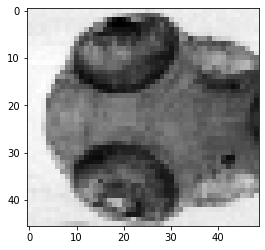

In [11]:
print("Original template size:", template.shape)

smallTemplate = smallImage[210:210+46, 131:131+49]
plt.imshow(smallTemplate, cmap="gray")

print("New template size: ", smallTemplate.shape)

As you can see from the resulting template, the resolution is worse, but it is still sufficient for the object-detection.


One thing to keep in mind is that the downsampling factor depends on the size of the object to find.  
Imagine we would downsample by a factor of 10 or 100, then the head region would be just a few pixel in the downsampled image and such that the chance to find it by template matching would decrease.  
Let's run now the detection with the downsampled images.

In [12]:
%time listDetections = matchTemplates(smallImage, [smallTemplate], nObjects=1)
listDetections

Wall time: 170 ms


[(BoundingBox: 1.00, xyxy:(131, 210, 179, 255), 0)]

Now we gain some speed improvement compared to the full resolution image !  
(for the template search only)

To show the bounding boxes on the full scale image, we have to upscale the coordinates they refer to. For this, we use the function `bbupscale`, which takes as argument the list of detections `listDetections` and the downscaling ratio and returns a new list with upscaled coordinates.

<Figure size 720x720 with 0 Axes>

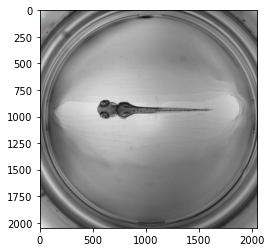

In [13]:
#We create a new list with coordinates in the full scale image
listDetectionsupscaled = MTM.bbupscale(listDetections, downscale_ratio)

plt.figure(figsize = (10,10))
plotDetections(image, listDetectionsupscaled)

This complete operation can also be performed automatically with minimal overhead inside the function `matchtemplates`. For this, we introduce an argument `downscaling_ratio`, an integer superior to 1.

In [14]:
image = io.imread(r"images/Fish.tif", -1)
template = image[842:842+184, 528:528+196]
listTemplates = [template]

%time listDetections = matchTemplates(image, listTemplates, nObjects=1, downscaling_ratio = 4)
listDetections

Wall time: 203 ms


[(BoundingBox: 0.97, xyxy:(528, 844, 723, 1027), 0)]

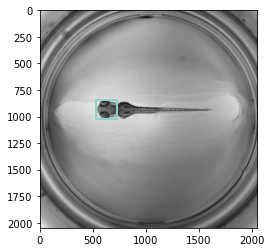

In [15]:
plotDetections(image, listDetections)

To sum up, we downscaled the image and the template, ran the detection with the downscaled version, and finally rescaled the detected bounding boxes back to the full resolution image before display.

## Conclusion

Finally, we can try to combine both methods to achieve the fastest possible computation time:

In [18]:
image = io.imread(r"images/Fish.tif", -1)
template = image[842:842+184, 528:528+196]
listTemplates = [template]

%time listDetections = matchTemplates(image, listTemplates, nObjects=1, searchBox=(76,781,1856,353), downscaling_ratio = 4)
listDetections

Wall time: 40 ms


[(BoundingBox: 1.00, xyxy:(528, 841, 723, 1024), 0)]

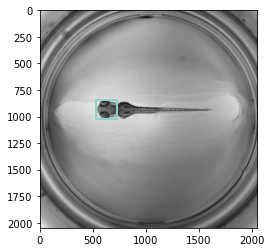

In [19]:
plotDetections(image, listDetections)

Overall, the combination of both methods allowed a **98%** reduction in compute time.

In this tutorial, we showed 2 simple ways to speed-up execution:
- using a search region
- downscaling the image and the template, then rescale the bounding-boxes
  
Also even if the gain is just a fraction of second per image, if you ran the detection on thousands of images, this would make a real difference !
